In [5]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Initial Eda

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/kaggle/input/quora-train/train.csv')

In [8]:
df.shape

(404290, 6)

In [9]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
df.duplicated().sum()

0

is_duplicate
0    255027
1    149263
Name: count, dtype: int64
is_duplicate
0    63.080215
1    36.919785
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

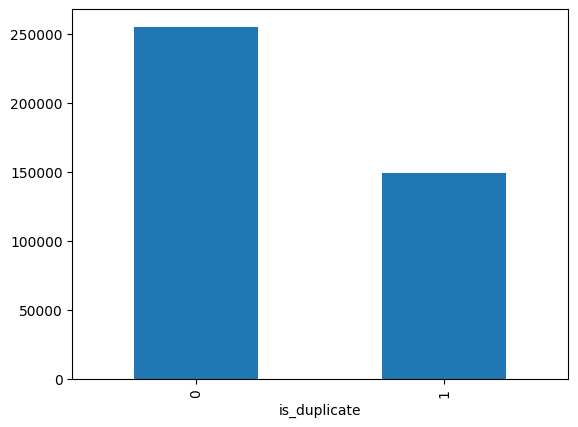

In [13]:
# distribution of duplicate and non-duplicate questions
print(df['is_duplicate'].value_counts())

print((df['is_duplicate'].value_counts()/df['is_duplicate'].count())*100)

df['is_duplicate'].value_counts().plot(kind='bar')

In [14]:
# repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537933
Number of questions getting repeated 111780


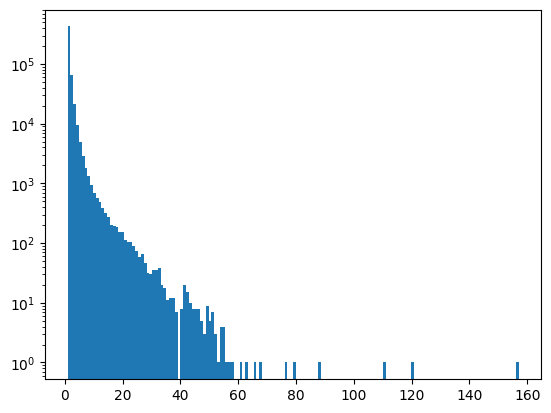

In [15]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# using only Bag of Words

In [5]:
new_df = df.sample(50000)

In [6]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       1
is_duplicate    0
dtype: int64

In [7]:
new_df.duplicated().sum()

0

In [8]:
new_df.dropna(inplace=True)

In [9]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
ques_df = new_df[['question1','question2']]
ques_df.shape

(49999, 2)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [12]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(49999, 6000)

In [13]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [14]:
temp_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
33200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
28458,0,0,0,0,0,0,0,0,0,0,...,2,0,0,1,0,0,0,0,0,0
147906,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# model building just using bag of words and not doing pre-processing , feature engineering

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.753

In [17]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.738

# model building after doing feature engineering

In [18]:
# Feature Engineering

new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
33200,33200,61031,61032,What is the difference between EasySendy Pro a...,Any all-in-one IT Help Desk Software like Spic...,0,59,85
67953,67953,117522,117523,"What's a witty response to ""I don't give a fuc...",Why don't I care about my marks and studies?,0,67,44
189978,189978,88063,168550,What does it mean if a dog throws up yellow li...,What causes a dog to throw up white liquid?,1,51,43
28458,28458,52774,52775,What can get you fired from your job?,What would you do if you get fired from your job?,0,37,49
147906,147906,233323,140796,What picture are you most proud of?,"Who is the most beautiful person you know, add...",0,35,55


In [19]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
33200,33200,61031,61032,What is the difference between EasySendy Pro a...,Any all-in-one IT Help Desk Software like Spic...,0,59,85,9,14
67953,67953,117522,117523,"What's a witty response to ""I don't give a fuc...",Why don't I care about my marks and studies?,0,67,44,14,9
189978,189978,88063,168550,What does it mean if a dog throws up yellow li...,What causes a dog to throw up white liquid?,1,51,43,11,9
28458,28458,52774,52775,What can get you fired from your job?,What would you do if you get fired from your job?,0,37,49,8,11
147906,147906,233323,140796,What picture are you most proud of?,"Who is the most beautiful person you know, add...",0,35,55,7,10


In [20]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [21]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
33200,33200,61031,61032,What is the difference between EasySendy Pro a...,Any all-in-one IT Help Desk Software like Spic...,0,59,85,9,14,0
67953,67953,117522,117523,"What's a witty response to ""I don't give a fuc...",Why don't I care about my marks and studies?,0,67,44,14,9,1
189978,189978,88063,168550,What does it mean if a dog throws up yellow li...,What causes a dog to throw up white liquid?,1,51,43,11,9,5
28458,28458,52774,52775,What can get you fired from your job?,What would you do if you get fired from your job?,0,37,49,8,11,7
147906,147906,233323,140796,What picture are you most proud of?,"Who is the most beautiful person you know, add...",0,35,55,7,10,2


In [22]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
33200,33200,61031,61032,What is the difference between EasySendy Pro a...,Any all-in-one IT Help Desk Software like Spic...,0,59,85,9,14,0,23
67953,67953,117522,117523,"What's a witty response to ""I don't give a fuc...",Why don't I care about my marks and studies?,0,67,44,14,9,1,20
189978,189978,88063,168550,What does it mean if a dog throws up yellow li...,What causes a dog to throw up white liquid?,1,51,43,11,9,5,20
28458,28458,52774,52775,What can get you fired from your job?,What would you do if you get fired from your job?,0,37,49,8,11,7,18
147906,147906,233323,140796,What picture are you most proud of?,"Who is the most beautiful person you know, add...",0,35,55,7,10,2,17


In [23]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
33200,33200,61031,61032,What is the difference between EasySendy Pro a...,Any all-in-one IT Help Desk Software like Spic...,0,59,85,9,14,0,23,0.00
67953,67953,117522,117523,"What's a witty response to ""I don't give a fuc...",Why don't I care about my marks and studies?,0,67,44,14,9,1,20,0.05
189978,189978,88063,168550,What does it mean if a dog throws up yellow li...,What causes a dog to throw up white liquid?,1,51,43,11,9,5,20,0.25
28458,28458,52774,52775,What can get you fired from your job?,What would you do if you get fired from your job?,0,37,49,8,11,7,18,0.39
147906,147906,233323,140796,What picture are you most proud of?,"Who is the most beautiful person you know, add...",0,35,55,7,10,2,17,0.12


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


minimum characters 1
maximum characters 354
average num of characters 59


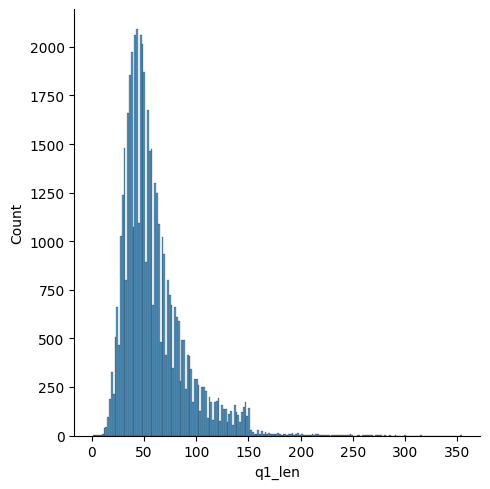

In [24]:
# Analysis of features
sns.displot(new_df['q1_len'])
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


minimum characters 2
maximum characters 823
average num of characters 60


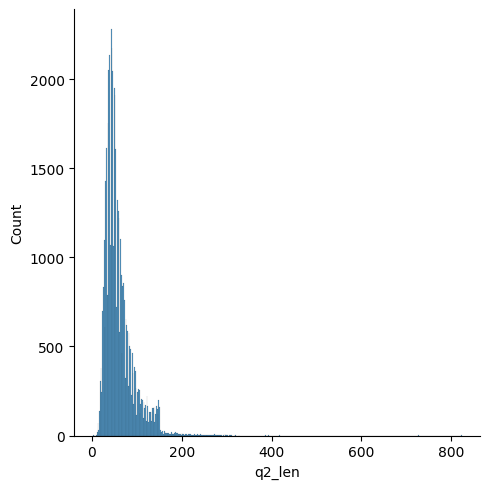

In [25]:
sns.displot(new_df['q2_len'])
print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


minimum words 1
maximum words 71
average num of words 10


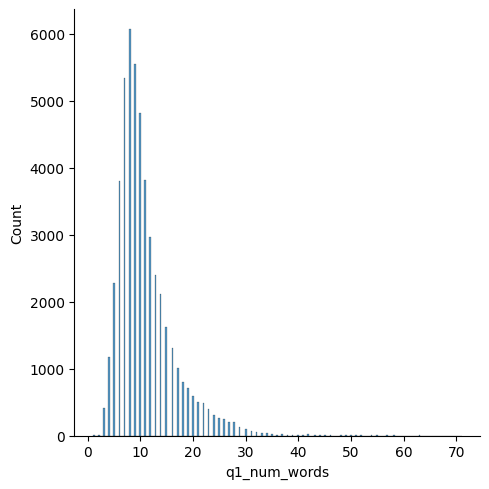

In [26]:
sns.displot(new_df['q1_num_words'])
print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


minimum words 1
maximum words 149
average num of words 11


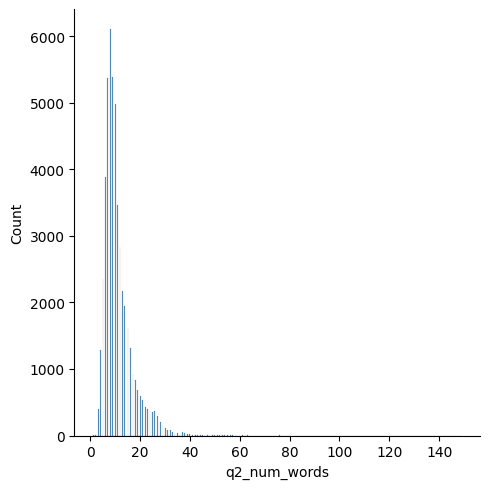

In [27]:
sns.displot(new_df['q2_num_words'])
print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

/tmp/ipykernel_181/2492214095.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_181/2492214095.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or 

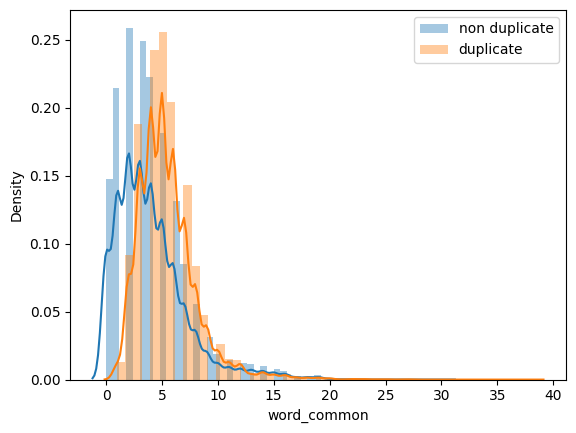

In [28]:
# common words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

/tmp/ipykernel_181/2776808923.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_181/2776808923.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `

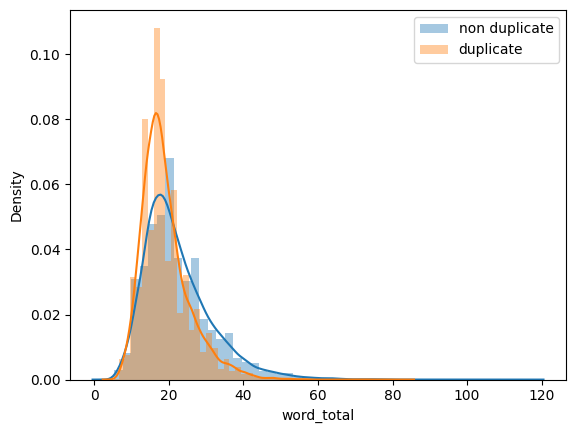

In [29]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

/tmp/ipykernel_181/542246512.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_181/542246512.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `hi

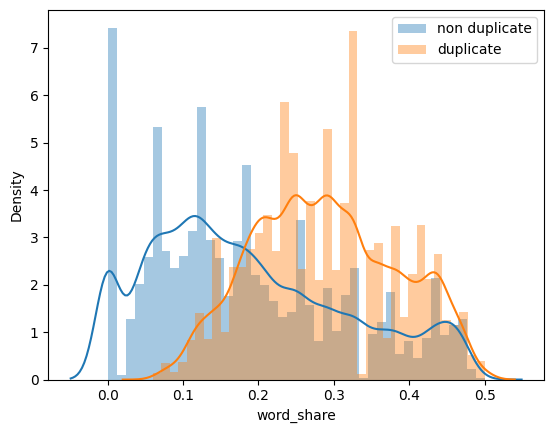

In [30]:
# word share
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [31]:
# making a final dataframe 
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(49999, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
33200,0,59,85,9,14,0,23,0.00
67953,0,67,44,14,9,1,20,0.05
189978,1,51,43,11,9,5,20,0.25
28458,0,37,49,8,11,7,18,0.39
147906,0,35,55,7,10,2,17,0.12


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [33]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)


In [34]:
temp_df.shape

(49999, 6000)

In [35]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(49999, 6008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
33200,0,59,85,9,14,0,23,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
67953,0,67,44,14,9,1,20,0.05,0,0,...,0,0,0,0,0,0,0,0,0,0
189978,1,51,43,11,9,5,20,0.25,0,0,...,0,0,0,0,0,0,0,0,0,0
28458,0,37,49,8,11,7,18,0.39,0,0,...,0,2,0,0,1,0,0,0,0,0
147906,0,35,55,7,10,2,17,0.12,0,0,...,0,1,0,0,0,0,0,0,0,0


In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred) #before it was 0.75 by just using Bow

0.78

In [38]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred) #before it was 0.73 by just using Bow

0.7758